In [3]:
from utils.experiment_utils import get_all_experiments_info, load_best_model
import torch
import os
import hydra
from omegaconf import DictConfig, OmegaConf

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from notebooks.mnist_classifier.mnist_tiny_cnn import TinyCNN

from mixer.mixer import SetMixer
from datasets.mnist import MNISTDataset

from itertools import product

In [4]:
device = 'cuda'
configs = get_all_experiments_info('outputs/', False)
cfg = [c for c in configs if 'mnist_multinomial' in c['name'] 
                    and c['config']['experiment']['batch_size'] == 8]

In [5]:
# load + prep dataset
def prepare_dataset(dataset_cfg):
    # probs = np.column_stack((np.linspace(0, 1, num_probs), 1 - np.linspace(0, 1, num_probs)))
    dataset = hydra.utils.instantiate(dataset_cfg)
    # dataset.probs = probs
    # dataset.data, _, _ = dataset.make_sets()
    return dataset

# load encoder and move to device
def load_model(cfg, path, device):
    enc = hydra.utils.instantiate(cfg['encoder'])
    gen = hydra.utils.instantiate(cfg['generator'])
    state = load_best_model(path)
    enc.load_state_dict(state['encoder_state_dict'])
    gen.model.load_state_dict(state['generator_state_dict'])
    enc.eval()
    gen.eval()
    enc.to(device)
    gen.to(device)
    return enc, gen

In [6]:
mixer = hydra.utils.instantiate(cfg[0]['config']['mixer'])

In [7]:
dataset = prepare_dataset(cfg[0]['config']['dataset'])

dataset.data.shape

torch.Size([9999, 100, 1, 28, 28])

In [8]:
classy = TinyCNN()
classy.load_state_dict(torch.load('notebooks/mnist_classifier/mnist_tinycnn.pth'))
classy.to('cuda')

TinyCNN(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=9216, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [9]:
def simplex_grid(dim, points_per_dim):
    lin = np.linspace(0, 1, points_per_dim)
    grid = np.array(list(product(*([lin] * dim))))
    grid = grid[np.isclose(grid.sum(axis=1), 1)]  # keep only rows that sum to 1
    return grid

points_per_dim = 2
k = 3

set_size = 100

mix_probs_labels = simplex_grid(k, points_per_dim)

# fr_dist = multinomial_fr(mix_probs)

n_sets = len(mix_probs_labels)

mix_probs = torch.tensor(np.repeat(mix_probs_labels, n_sets//k, axis=1))

dataset = MNISTDataset(n_classes=k, n_sets=n_sets, set_size=5000)
mixer = SetMixer(k=k, mixed_set_size=set_size, n_mixed_sets=n_sets)


In [10]:
mixed_sets = mixer.prescribed_mixing(dataset.data.flatten(start_dim=2), mix_probs)

In [11]:
mixed_sets = mixed_sets.to(torch.float).to('cuda')

In [12]:
d = {
    "Encoder" : [],
    "Generation class error" : []
}

with torch.no_grad():

    for c in cfg:

        if c['encoder'] != 'KMEEncoder':

            encoder, generator = load_model(c['config'], c['dir'], 'cuda')
            
            rec = generator.sample(encoder(mixed_sets.reshape(n_sets, set_size, 1, 28, 28)), num_samples=100)

            preds = classy(rec.reshape(set_size*n_sets, 1, 28, 28)).argmax(dim=1).reshape(n_sets, set_size)

            compositions = torch.stack([(set_preds.bincount(minlength=10+1)) for set_preds in preds])

            est = compositions[:, :3].cpu().numpy()/100

            print(est)

            error = est - mix_probs_labels

            print(est)

            d['Encoder'].append(c['encoder'])
            d['Generation class error'].append((error**2).mean())
            print(d)

[[0.03 0.01 0.93] 100
 [0.01 0.95 0.03]
 [0.99 0.   0.01]]
[[0.03 0.01 0.93]
 [0.01 0.95 0.03]
 [0.99 0.   0.01]]
{'Encoder': ['ConvDistributionEncoder'], 'Generation class error': [np.float64(0.0010666666666666663)]}
[[0.15 0.46 0.27] 100
 [0.65 0.   0.31]
 [0.02 0.8  0.05]]
[[0.15 0.46 0.27]
 [0.65 0.   0.31]
 [0.02 0.8  0.05]]
{'Encoder': ['ConvDistributionEncoder', 'MNISTPCAEncoder'], 'Generation class error': [np.float64(0.0010666666666666663), np.float64(0.4320555555555556)]}
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
{'Encoder': ['ConvDistributionEncoder', 'MNISTPCAEncoder', 'WormholeEncoder'], 'Generation class error': [np.float64(0.0010666666666666663), np.float64(0.4320555555555556), np.float64(0.4444444444444444)]}


In [23]:
with torch.no_grad():
    c = cfg[3]

    encoder, generator = load_model(c['config'], c['dir'], 'cuda')

    rec = generator.sample(encoder(mixed_sets.reshape(n_sets, set_size, 1, 28, 28)), num_samples=10)


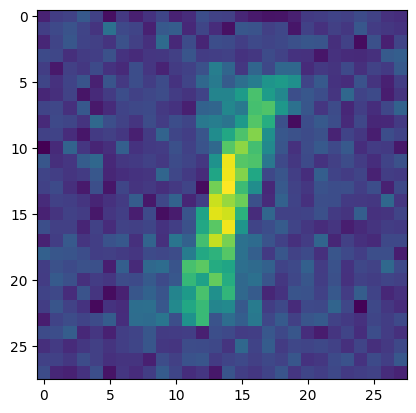

In [24]:
plt.imshow(rec.reshape(set_size*n_sets, 28, 28)[0].cpu())

In [ ]:
plt.imshow(rec.)

torch.Size([3, 100, 784])